# Setup

Díky využití služeb  Google Colaboratory jsou veškeré příklady uvedené v této kapitole implementovány za využité jediného souboru Jupyter notebooku, který je konfigurován tak, aby jej po drobných úpravách (zejména lokalizaci příslušných dat uvnitř vlastního Google disku a autorizaci přístupu k tomuto Google disku uvnitř skriptu) mohl v prohlížeči spustit každý, kdo k němu prostřednictvím odkazu  získá přístup.

In [1]:
### these should go easy
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 150)

import numpy as np
import os
import string
import collections
import math
import random
import statistics as stat
import re
import unicodedata
import json

# Natural Language Processing Toolkit - we use it especially for building bigrams
import nltk
from nltk.collocations import *

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
# urllib and requests do basically the same, but my preferences are changing all the time, so let's import both
from urllib.parse import quote  
import requests
from bs4 import BeautifulSoup
### in some cases I prefer Element Tree
import xml.etree.cElementTree as ET


### for visualization
# in some cases I use matplotlib, which is much easier to configure, elsewhere I prefer Plotly, which is more "sexy"
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns

### to generate wordcloud data
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func

# There is a lot of changes in Plotly nowadays. Perhaps some modifications of the code will be needed at some point
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

### for network analysis
import networkx as nx

### to export data to Google Spreadsheet
import gspread
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### for data exchange with local harddrive
from google.colab import files

### for integration with sciencedata.dk datastorage (see https://pypi.org/project/sddk/)
!pip install sddk
import sddk

For an external data storage, this notebook relies on sciencedata.dk, accessed via sddk package. To write data to sciencedata.dk, you have to have a user account there (what is completely free and requires only a very simple configuration). However, for reading data from there within this notebook, you do not need such account.

In [4]:
### in the case you want just read data from sciencedata.dk, skip this cell
conf = sddk.configure_session_and_url()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [0]:
# establish connection with particular sheet by its url:
### useful for fast data export, feel free to skip
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1LtHGTRt3uygNLBq386wKV6G7-HitkWaUTh5V6UTGnVM/edit?usp=sharing")

# Getting Czech NT Data 

In [2]:
### open the New Testament in Czech Ecumenical Translation from GitHUB

url = "https://raw.githubusercontent.com/getbible/Bibles/master/Czech__Czech_CEP__cep__LTR.txt"
textfile = urlopen(url).read().decode("utf-8")
textfile[:100]

'01O||1||1||Na počátku stvořil Bůh nebe a zemi.\r\n01O||1||2||Země byla pustá a prázdná a nad propastno'

# Requirements

In [162]:
import pandas as pd
import numpy as np
import json
import nltk

### Beautiful Soup and Urllib
### for scrapping of web data and parsing xml files
from urllib.request import urlopen
# urllib and requests do basically the same, but my preferences are changing all the time, so let's import both
from urllib.parse import quote  
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

In [203]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (4.25, 4.25)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

# Bible & NT in Czech Ecumenic Translation

In [17]:
bible = pd.read_csv("data/Bible_CEP.csv")
bible.head(5)
# alternatively, you can retrieve the data on your own from here:
#url = "https://raw.githubusercontent.com/getbible/Bibles/master/Czech__Czech_CEP__cep__LTR.txt"
#bible = pd.read_csv(url, sep=r"\|+", names=["book", "c", "v", "text"])

,book,c,v,text
0,01O,1,1,Na počátku stvořil Bůh nebe a zemi.
1,01O,1,2,Země byla pustá a prázdná a nad propastnou tůn...
2,01O,1,3,"I řekl Bůh: ""Buď světlo!"" A bylo světlo."
3,01O,1,4,"Viděl, že světlo je dobré, a oddělil světlo od..."
4,01O,1,5,Světlo nazval Bůh dnem a tmu nazval nocí. Byl ...


In [28]:
nt = bible[bible["book"].str.endswith("N")].copy()
nt.reset_index(drop=True, inplace=True)
nt.head(5)

,book,c,v,text
0,40N,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,40N,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,40N,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,40N,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,40N,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [29]:
nt_books_keys = nt["book"].unique()
nt_books_keys

array(['40N', '41N', '42N', '43N', '44N', '45N', '46N', '47N', '48N',
       '49N', '50N', '51N', '52N', '53N', '54N', '55N', '56N', '57N',
       '58N', '59N', '60N', '61N', '62N', '63N', '64N', '65N', '66N'],
      dtype=object)

In [30]:
# replace by standard book abbreviations
nt_books_abbrs = ['Mt', 'Mk', 'L', 'J', 'Sk', 'Ř', '1K', '2K', 'Ga', 'Ef', 'Fp', 'Ko', '1Te', '2Te', '1Tm', '2Tm', 'Tt', 'Fm', 'Žd', 'Jk', '1P', '2P', '1J', '2J', '3J', 'Ju', 'Zj']
nt_books_dict = dict(zip(nt_books_keys, nt_books_abbrs))
nt_books_dict["40N"]

'Mt'

In [32]:
nt["book_abbr"] = nt["book"].apply(lambda x: nt_books_dict[x])
nt = nt[["book_abbr", "c", "v", "text"]]
nt.head(5)

,book_abbr,c,v,text
0,Mt,1,1,"Listina rodu Ježíše Krista, syna Davidova, syn..."
1,Mt,1,2,"Abraham měl syna Izáka, Izák Jákoba, Jákob Jud..."
2,Mt,1,3,"Juda Farese a Záru z Támary, Fares měl syna Ch..."
3,Mt,1,4,"Aram měl syna Amínadaba, Amínadab Naasona, Naa..."
4,Mt,1,5,"Salmón měl syna Boaze z Rachaby, Boaz Obéda z ..."


In [33]:
nt[nt["book_abbr"]=="J"]["text"].values[:10]

array(['Na počátku bylo Slovo, to Slovo bylo u Boha, to Slovo byl Bůh.',
       'To bylo na počátku u Boha.',
       'Všechno povstalo skrze ně a bez něho nepovstalo nic, co jest.',
       'V něm byl život a život byl světlo lidí.',
       'To světlo ve tmě svítí a tma je nepohltila.',
       'Od Boha byl poslán člověk, jménem Jan.',
       'Ten přišel proto, aby vydal svědectví o tom světle, aby všichni uvěřili skrze něho.',
       'Jan sám nebyl tím světlem, ale přišel, aby o tom světle vydal svědectví.',
       'Bylo tu pravé světlo, které osvěcuje každého člověka; to přicházelo do světa.',
       'Na světě byl, svět skrze něj povstal, ale svět ho nepoznal.'],
      dtype=object)

# Functions for Data Cleaning and Preprocessing

In [104]:
def czech_sentences_maker(string):
  """splits text into sentences (not needed for the NT)"""
  text_splitted = re.split('([a-z|\"|ů|í|á|\d\d\d\d])(\.|\?|\!\s)', string)  
  sentences = []
  n = 0
  for element in text_splitted:
    n = n + 1
    if n == 1:
      sentence_main = element
    if n == 2:
      sentence_ending = element
    if n == 3:
      sentence_separator = element
      sentences.append(sentence_main + sentence_ending + sentence_separator)
      n = 0
  return sentences

def lemmata_filtered(string):
  try:
    url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(string)
    resp = urlopen(url)
    file = resp.read().decode("utf-8")
    result = dict(json.loads(file))["result"]
    soup = BeautifulSoup(result, 'html.parser')
    lemmata = []
    for token in soup.find_all("token"):
      if token["tag"].startswith(("V","N","A","C","D")):
        lemma = token["lemma"].partition("-")[0].partition("_")[0]
        if "`" in lemma:
          lemma = lemma.partition("`")[2]
        if len(lemma) > 1:
          lemmata.append(lemma)
  except:
    lemmata = [""]
  return lemmata

# Short one sentence long testing

In [105]:
test_string = "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!"
test_data = []
url = 'http://lindat.mff.cuni.cz/services/morphodita/api/tag?data=' + quote(test_string)
resp = urlopen(url)
file = resp.read().decode("utf-8")
result = dict(json.loads(file))["result"]
soup = BeautifulSoup(result, 'html.parser')
for token in soup.find_all("token"):
  lemma = token["lemma"].partition("-")[0].partition("_")[0]
  test_data.append([token.get_text(), token["tag"], lemma])
test_data

[['Hlas', 'NNIS1-----A----', 'hlas'],
 ['volajícího', 'AGIS2-----A----', 'volající'],
 ['na', 'RR--6----------', 'na'],
 ['poušti', 'NNFS6-----A----', 'poušť'],
 [':', 'Z:-------------', ':'],
 ['Připravte', 'Vi-P---2--A----', 'připravit'],
 ['cestu', 'NNFS4-----A----', 'cesta'],
 ['Páně', 'NNMS2-----A---2', 'Pán'],
 [',', 'Z:-------------', ','],
 ['vyrovnejte', 'Vi-P---2--A----', 'vyrovnat'],
 ['mu', 'PHZS3--3-------', 'on'],
 ['stezky', 'NNFP4-----A----', 'stezka'],
 ['!', 'Z:-------------', '!']]

In [106]:
nt.values.tolist()[:3]

[['Mt', 1, 1, 'Listina rodu Ježíše Krista, syna Davidova, syna Abrahamova.'],
 ['Mt',
  1,
  2,
  'Abraham měl syna Izáka, Izák Jákoba, Jákob Judu a jeho bratry,'],
 ['Mt',
  1,
  3,
  'Juda Farese a Záru z Támary, Fares měl syna Chesróma, Chesróm Arama.']]

In [72]:
pd.DataFrame(test_data).to_csv("data/test_sentence.csv", index=False)

In [73]:
%%time

### MAIN FUNCTION APPLIATION
### the text is lemmatized verse by verse and a dictionary of NT books is formed
### the dictionary element for each book is a dictionary containing:
### (1) "book_length_orig" = number of words in the source text
### (2) "book_length_filtered" = number of lemmatized words in the filtered text
### (3) "book_lemmata" = filtered lemmata as a list of words
### (4) "book_by_verse" = a list of list with cells for (a) book chapter, (b) verse number, (c) original text of the verse, (d) filtered lemmata for the verse

nt_data = {}
for book_abbr in nt["book_abbr"].unique().tolist():
  actual_book = nt[nt["book_abbr"]==book_abbr]
  book_lemmata = [] 
  book_length_orig = 0
  book_by_verse = []
  for verse_row in actual_book.values.tolist():
    verse_lemmata = lemmata_filtered(verse_row[3])
    book_lemmata.extend(verse_lemmata)
    book_length_orig = book_length_orig + len(str(verse_row[3]).split())
    book_by_verse.append([verse_row[1], verse_row[2], verse_row[3], verse_lemmata])
  book_length_filtered = len(book_lemmata)
  nt_data.update({book_abbr : {"book_length_orig" : book_length_orig, "book_length_filtered" : book_length_filtered, "book_lemmata" : book_lemmata, "book_by_verse" : book_by_verse}})

In [74]:
print(nt_data["Mk"]["book_lemmata"][:100])

['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží', 'být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta', 'hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka', 'stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích', 'celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán', 'Jan', 'být', 'odít', 'velbloudí', 'srst', 'mít', 'kožený', 'pás', 'bok', 'jíst', 'kobylka', 'med', 'divoký', 'včela', 'kázat', 'přicházet', 'silný', 'být', 'být', 'hodný', 'sklonit', 'rozvázat', 'řemínek', 'obuv', 'být', 'křtít', 'voda', 'být', 'křtít', 'duch', 'svatý', 'den', 'přijít', 'Ježíš', 'Nazaret', 'Galilea', 'být', 'Jordán', 'Jan', 'pokřtít', '', 'nebe', 'ozvat', 'hlas', 'být', 'milovaný', 'syn', 'být', 'vyvolit', 'hned', 'duch', 'vyvést', 'poušť']


In [75]:
with open("data/nt_data.json", "w") as f:
    json.dump(nt_data, f)
# to read it back, use:
# nt_data = json.load(open("data/nt_data.json"))
    

# To start with preprocessed data

In [51]:
nt_data = json.load(open("data/nt_data.json"))

In [58]:
print(nt_data["Mk"]["book_by_verse"][:5])

[[1, 1, 'Počátek evangelia Ježíše Krista, Syna Božího.', ['počátek', 'evangelium', 'Ježíš', 'Kristus', 'syn', 'boží']], [1, 2, "Je psáno u proroka Izaiáše: 'Hle, já posílám posla před tvou tváří, by ti připravil cestu.", ['být', 'psát', 'prorok', 'Izaiáš', 'posílat', 'posel', 'tvář', 'být', 'připravit', 'cesta']], [1, 3, "Hlas volajícího na poušti: Připravte cestu Páně, vyrovnejte mu stezky!'", ['hlas', 'volající', 'poušť', 'připravit', 'cesta', 'Pán', 'vyrovnat', 'stezka']], [1, 4, 'To se stalo, když Jan Křtitel vystoupil na poušti a kázal: "Čiňte pokání a dejte se pokřtít na odpuštění hříchů."', ['stát', 'Jan', 'křtitel', 'vystoupit', 'poušť', 'kázat', 'činit', 'pokání', 'dát', 'pokřtít', 'odpuštění', 'hřích']], [1, 5, 'Celá judská krajina i všichni z Jeruzaléma vycházeli k němu, vyznávali své hříchy a dávali se od něho křtít v řece Jordánu.', ['celý', 'judský', 'krajina', 'Jeruzalém', 'vycházet', 'vyznávat', 'hřích', 'dávat', 'křtít', 'řeka', 'Jordán']]]


In [94]:
def remove_spacewords(lemmata_list):
    return [l for l in lemmata_list if len(l) > 0]

for key in nt_data.keys():
    new_lemmata = remove_spacewords(nt_data[key]["book_lemmata"])
    nt_data[key]["book_lemmata"] = new_lemmata

In [96]:
### for some overview it might be easier to use a dataframe format
nt_data_df = pd.DataFrame.from_dict(nt_data, orient="index")
nt_data_df.head(4)

,book_length_orig,book_length_filtered,book_lemmata,book_by_verse
Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David..."
Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ..."
L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy..."
J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u..."


In [97]:
nt_data_df["book_length_orig"].sum()

134188

In [98]:
nt_data_df["book_length_filtered"].sum()

71691

In [99]:
### TF separately
TF = nt_data["J"]["book_lemmata"].count("učedník") / nt_data["J"]["book_length_orig"]
TF

0.005295488244016098

In [102]:
ev_wordfreqs = pd.DataFrame()
for ev in ["Mt", "Mk", "L", "J"]:
    wordcounts_raw = nltk.FreqDist(nt_data[ev]["book_lemmata"]).most_common(11)[1:]
    ev_wordfreqs[ev] = [tup[0] + " ({0})".format(str(np.round(tup[1] / nt_data[ev]["book_length_orig"], 5))) for tup in wordcounts_raw]
ev_wordfreqs

,Mt,Mk,L,J
0,říci (0.01362),říci (0.01405),říci (0.01433),říci (0.01793)
1,Ježíš (0.00934),Ježíš (0.00864),mít (0.00738),Ježíš (0.01553)
2,mít (0.0069),mít (0.00721),Ježíš (0.00619),otec (0.00826)
3,člověk (0.0063),přijít (0.00598),člověk (0.00608),mít (0.00791)
4,jít (0.00613),jít (0.00598),přijít (0.00526),přijít (0.006)
5,syn (0.00589),člověk (0.00531),dát (0.00412),odpovědět (0.00572)
6,přijít (0.00589),učedník (0.00418),syn (0.00407),učedník (0.0053)
7,dát (0.00446),jak (0.00342),jít (0.00396),svět (0.00501)
8,odpovědět (0.00422),říkat (0.00332),den (0.00391),dát (0.00466)
9,učedník (0.00422),dát (0.00304),jak (0.00336),člověk (0.00459)


In [107]:
ev_wordfreqs.to_csv("CEP_ev_wordfreqs.csv", index=False)

# Czech networks

In [111]:
# for convenience, you can simply start here
nt_data = json.load(open("data/nt_data.json"))
# nt_data = sddk.read_file("https://sciencedata.dk/shared/d58d13b674881c9b7ca8ba3dff25c51d?download", "dict")
  
evangelia = ["Mt", "Mk", "L", "J"]

In [112]:
### after recent changes, it is more meaningful to turn to dataframe here

nt_data = pd.DataFrame(nt_data).T.reset_index()
nt_data.head(4)

,index,book_length_orig,book_length_filtered,book_lemmata,book_by_verse
0,Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David..."
1,Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ..."
2,L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy..."
3,J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u..."


In [134]:
nt_data.rename(columns={"index": "author"}, inplace=True)
nt_data.head(4)

,author,book_length_orig,book_length_filtered,book_lemmata,book_by_verse
0,Mt,16816,9613,"[listina, rod, Ježíš, Kristus, syn, Davidov, s...","[[1, 1, Listina rodu Ježíše Krista, syna David..."
1,Mk,10537,5373,"[počátek, evangelium, Ježíš, Kristus, syn, bož...","[[1, 1, Počátek evangelia Ježíše Krista, Syna ..."
2,L,18425,9608,"[již, mnohý, pokusit, sepsat, vypravování, udá...","[[1, 1, I když se již mnozí pokusili sepsat vy..."
3,J,14163,7486,"[počátek, být, slovo, slovo, být, bůh, slovo, ...","[[1, 1, Na počátku bylo Slovo, to Slovo bylo u..."


In [117]:
def network_from_list_of_lists(list_of_lists):
    stringlist = [" ".join(el) for el in list_of_lists]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(stringlist)
    Xc = X.T * X
    wordcounts = X.toarray().sum(axis=0)
    nodes_dict = dict([(pair[1], {"wordcount" : wordcounts[pair[1]]}) for pair in vectorizer.vocabulary_.items()])
    labels_mapping = dict([(pair[1], pair[0]) for pair in vectorizer.vocabulary_.items()])
    G = nx.from_numpy_matrix(Xc.toarray())
    G.remove_edges_from(nx.selfloop_edges(G))
    nx.set_node_attributes(G, nodes_dict)
    G = nx.relabel_nodes(G, labels_mapping)
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    total_weight = sum([int(n) for n in nx.get_edge_attributes(G, "weight").values()])
    for (u, v) in G.edges:
        G[u][v]["norm_weight"] = round((G[u][v]["weight"] / total_weight), 5)
        G[u][v]["distance"] = round(1 / (G[u][v]["weight"]), 5)
        G[u][v]["norm_distance"] = round(1 / (G[u][v]["norm_weight"] ), 5)
    return G

In [253]:
def network_formation_df(dataset, column, book_abbr, lexicon_size, threshold):
    '''From one or more documents within a dataframe with rows corresponding to individual documents,
    to be subsellected on the basis of author's name column, for instance'''
    works = dataset[dataset["author"]==book_abbr][column].tolist()
    works_merged = [item for sublist in works for item in sublist]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(works_merged).most_common(lexicon_size)]
    bigrams_list = []
    for work in works:
        lemmata_list = [lemma for lemma in work if lemma not in ["εἰμί", "být"]]
        bigrams_list.extend([bigram for bigram in nltk.bigrams(lemmata_list)])
    G = network_from_list_of_lists(bigrams_list)
    # filter for a subset of nodes and edges
    G.remove_nodes_from([n for n in G.nodes if n not in lexicon])
    G.remove_edges_from([(s,t) for (s,t) in G.edges if G[s][t]["weight"] < threshold])
    return G
                        
def network_from_lemmata_list(lemmata_list, lexicon_size, threshold):
    '''From a list of words'''
    lemmata_list = [lemma for lemma in lemmata_list if lemma not in ["být", "εἰμί"]]
    lexicon = [word_tuple[0] for word_tuple in nltk.FreqDist(lemmata_list).most_common(lexicon_size)]
    bigrams_list = [bigram for bigram in nltk.bigrams(lemmata_list)]
    G = network_from_list_of_lists(bigrams_list)
    # filter for a subset of nodes and edges
    G.remove_nodes_from([n for n in G.nodes if n not in lexicon])
    G.remove_edges_from([(s,t) for (s,t) in G.edges if G[s][t]["weight"] < threshold])
    return G

def ego_network_data(df, column, book_abbr, term, num_of_neighbours):
    '''create network and ego network on its basis
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    network = network_formation_df(df, column, book_abbr, 500, 1)
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    ego_network.remove_nodes_from([n for n in ego_network.nodes if n not in shortest_nodes])
    ego_network.remove_edges_from([e for e in ego_network.edges if e not in shortest_edges])
    #ego_network.remove_edges_from([e for e in ego_network.edges if (e[1], e[0]) not in shortest_edges])
    ego_network_data_prec = sorted(list(ego_network.edges.data("weight")), key=lambda tup: int(tup[2]), reverse=True)
    ego_network_data_complete = []
    for tup in ego_network_data_prec:
      if tup[1] == term:
        ego_network_data_complete.append([tup[1], tup[0], int(tup[2]), round(1 / int(tup[2]), 5)])
      else:
        ego_network_data_complete.append([tup[0], tup[1], int(tup[2]), round(1 / int(tup[2]), 5)])
    return ego_network_data_complete


def plot_network_simple(G, N_nodes=len(G.nodes), node_size_attr="wordcount", edge_width_attr="weight", margins=0.3, font_size=5, ax=None):
    """a more simple variant of the same"""
    nodes_sorted_tups =  node_sizes = sorted([(node[0], node[1][node_size_attr]) for node in G.nodes(data=True)], key=lambda x: x[1], reverse=True)
    nodes_lables_sorted = [tup[0] for tup in nodes_sorted_tups]
    ###
    H = G.subgraph(nodes_lables_sorted[:N_nodes])
    #node_colors = [color_dict[node] for node in H.nodes()]
    edge_sizes = [np.log2(w / 2) for w in nx.get_edge_attributes(H, edge_width_attr).values()]
    node_sizes = [w / 2 for w in nx.get_node_attributes(H, node_size_attr).values()]
    pos = nx.kamada_kawai_layout(H, weight="norm_distance")
    if ax == None:
        fig, ax = plt.subplots()
    x_min, x_max, y_min, y_max = np.min([p[0] for p in pos.values()]), np.max([p[0] for p in pos.values()]), np.min([p[1] for p in pos.values()]), np.max([p[1] for p in pos.values()]) 
    ax.set_xlim(x_min - margins, x_max + margins)
    ax.set_axis_off()
    layer_edges = nx.draw_networkx_edges(H,
                          pos=pos,
                          alpha=1,
                          width= edge_sizes,
                          style="solid",
                          edge_color="darkgray",
                          ax=ax)
    layer_nodes = nx.draw_networkx_nodes(H,
                           pos=pos,
                           node_size=node_sizes,
                           node_color="lightgrey",
                           linewidths=1,
                           ax=ax)
    layer_labels = nx.draw_networkx_labels(H,
                           pos=pos, 
                           font_size=font_size,
                           ax=ax)
    layers = [layer_edges, layer_nodes, layer_labels]
    return layers


def ego_network_drawing_reduced(network, term, num_of_neighbours, title, mode, dimensions, ax=None):
    '''derrive ego network from a preexisting network
    specify source term and number of neighbors
    includes only shortest paths from the source'''
    length, path = nx.single_source_dijkstra(network, term, target=None, weight="distance")
    shortest_nodes = list(length.keys())[0:num_of_neighbours+1]
    path_values_sorted = [dict_pair[1] for dict_pair in sorted(path.items(), key=lambda pair: list(length.keys()).index(pair[0]))]
    path_edges = []
    for path_to_term in path_values_sorted[1:num_of_neighbours+1]:
        path_edges.extend([tuple(sorted(bigram)) for bigram in nltk.bigrams(path_to_term)])
    shortest_edges = list(set(path_edges))
    ego_network = network.copy(as_view=False)
    ego_network.remove_nodes_from([n for n in ego_network.nodes if n not in shortest_nodes])
    ego_network.remove_edges_from([e for e in ego_network.edges if e not in shortest_edges])
    #ego_network.remove_edges_from([e for e in ego_network.edges if (e[1], e[0]) not in shortest_edges])
    layer = plot_network_simple(ego_network, ax=ax)
    return layer 

def ego_network_standard(dataset, column, book_abbr, term, mode, dimensions, ax=None):
    network = network_formation_df(dataset, column, book_abbr, 500, 1)
    ego_network_drawing_reduced(network, term, 30, book_abbr + " - " + term, mode, dimensions, ax=ax)

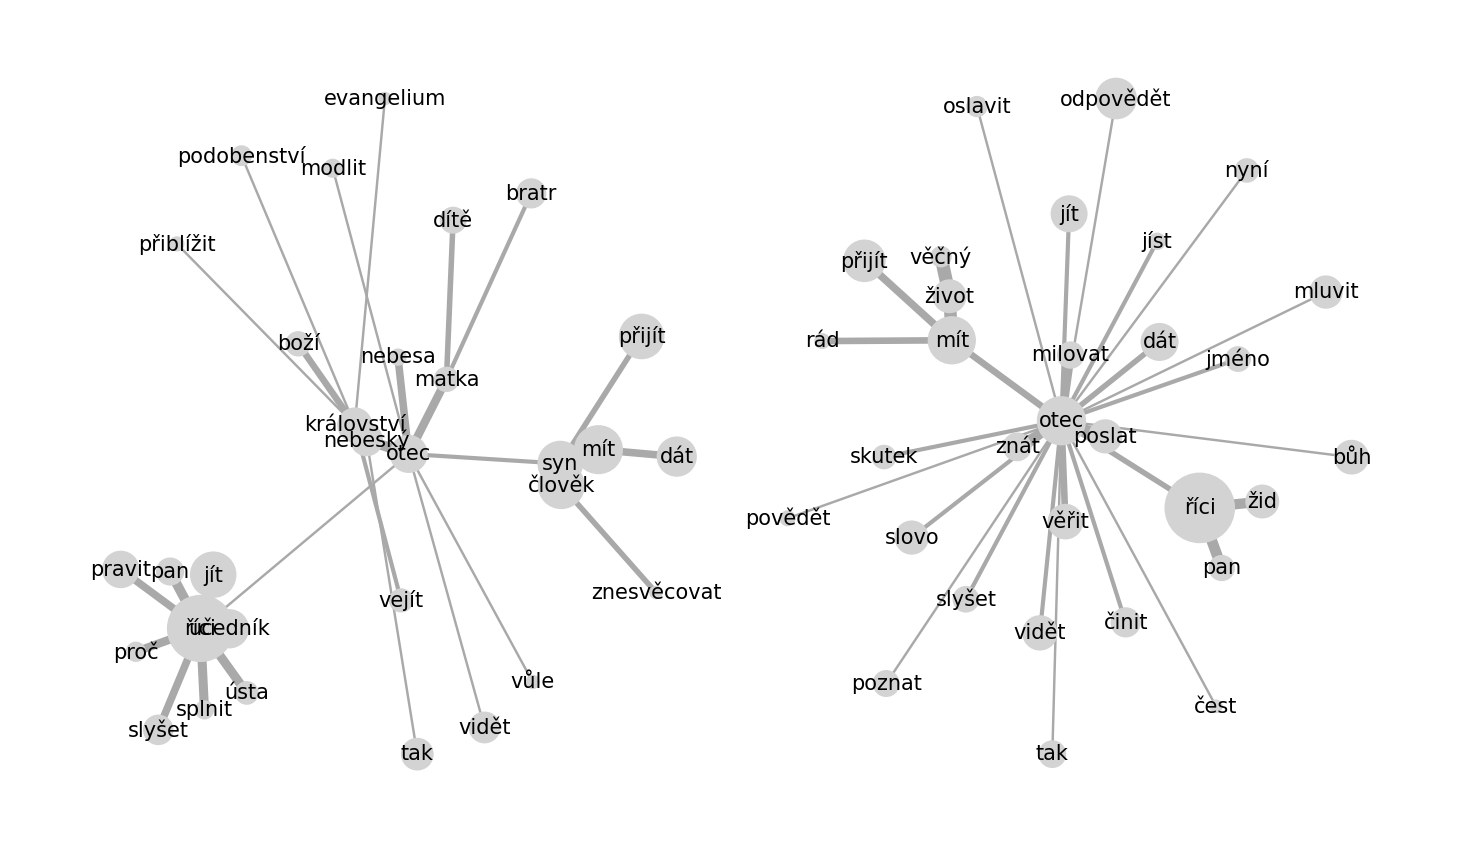

In [267]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.25, 2.2))
ego_network_standard(nt_data, "book_lemmata", "Mt", "otec", "online", "2D", ax=ax1)
ego_network_standard(nt_data, "book_lemmata", "J", "otec", "online", "2D", ax=ax2)
fig.tight_layout(pad=-2)

In [273]:
fig.savefig("figures/network_Mt+J_otec.png", bbox_inches='tight', pad_inches=0)
fig.savefig("figures/network_Mt+J_otec.eps", bbox_inches='tight', pad_inches=0)

In [276]:
network_data_overview = []
for book_abbr in evangelia:
    actual_network_data = list(network_formation_df(nt_data, "book_lemmata", book_abbr, 500, 2).edges.data("weight"))
    actual_network_data = sorted(actual_network_data, key=lambda x: int(x[2]), reverse=True)
    network_data_overview.append(actual_network_data[:10])

In [277]:
evanglia_networks_overview = pd.DataFrame(network_data_overview).T
evanglia_networks_overview.columns = ["Mt", "Mk", "L", "J"]
evanglia_networks_overview

,Mt,Mk,L,J
0,"(království, nebeský, 31)","(boží, království, 12)","(boží, království, 30)","(věčný, život, 18)"
1,"(syn, člověk, 31)","(duch, zlý, 11)","(syn, člověk, 26)","(mít, život, 16)"
2,"(učedník, říci, 16)","(syn, člověk, 11)","(duch, svatý, 13)","(syn, člověk, 13)"
3,"(mít, syn, 13)","(duch, čistý, 10)","(den, kdy, 12)","(pan, říci, 12)"
4,"(jít, říci, 12)","(jít, říci, 10)","(pan, říci, 12)","(jít, říci, 11)"
5,"(farizeus, zákoník, 11)","(učedník, říci, 10)","(pán, říci, 12)","(říci, žid, 11)"
6,"(nebeský, otec, 11)","(matka, otec, 7)","(učedník, říci, 12)","(boží, syn, 10)"
7,"(prorok, ústa, 11)","(chtít, říci, 6)","(jak, říci, 11)","(otec, poslat, 10)"
8,"(pan, říci, 10)","(dům, vejít, 6)","(jít, říci, 10)","(jak, moci, 9)"
9,"(boží, syn, 9)","(jak, říci, 6)","(bůh, chválit, 9)","(otec, znát, 9)"


In [0]:
set_with_dataframe(sh.add_worksheet(title="evanglia_networks_overview", rows=1, cols=1), pd.DataFrame(evanglia_networks_overview))

In [0]:
### generate networks and show words with max betweenness
def generate_network_and_betweenness(name):
    network = network_formation_df(nt_data, name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_dict = sorted(betweenness_dict.items(), key = lambda x : x[1], reverse=True)
    return [name, betweenness_dict]
for book in evangelia:
  print(generate_network_and_betweenness(book))


['Mt', [('říci', 0.477997862758568), ('Ježíš', 0.20643674359039602), ('mít', 0.15384003765615856), ('člověk', 0.15016983436378903), ('syn', 0.13019786445479142), ('učedník', 0.11447917461771366), ('přijít', 0.10146596103774946), ('dát', 0.0808812304404244), ('jít', 0.07603639247216075), ('pravit', 0.051323478275619325), ('otec', 0.04519163083394821), ('den', 0.041330602413725846), ('ústa', 0.03938630638882528), ('nebe', 0.034959163422639494), ('odpovědět', 0.03315268554563265), ('vidět', 0.032275950097108784), ('boží', 0.03214767320560771), ('království', 0.030484314174490497), ('země', 0.029360566199357136), ('jméno', 0.02714381429746669), ('prorok', 0.024178603838553463), ('chtít', 0.022197202927681518), ('život', 0.021792229600793838), ('služebník', 0.020873088568302674), ('vejít', 0.020710887209627764), ('celý', 0.020322876116327), ('dobrý', 0.019080392506085203), ('tělo', 0.019006182734142434), ('nebeský', 0.018968017708571865), ('ruka', 0.018017072488105235), ('duch', 0.017517746

In [0]:
def generate_network_and_count(name):
    network = network_formation_df(nt_data, name, 500, 2)
    betweenness_dict = nx.betweenness_centrality(network, weight="distance", normalized=True)
    betweenness_mean = stat.mean(list(betweenness_dict.values()))
    try: betweenness_otec = betweenness_dict["otec"] / betweenness_mean
    except: betweenness_otec = 0
    freq_otec = nt_data[name]["book_lemmata"].count("otec") / nt_data[name]["book_length_orig"]   
    try: betweenness_matka = betweenness_dict["matka"] / betweenness_mean
    except: betweenness_matka = 0
    freq_matka = nt_data[name]["book_lemmata"].count("matka") / nt_data[name]["book_length_orig"]
    try: betweenness_syn = betweenness_dict["syn"] / betweenness_mean
    except: betweenness_syn = 0
    freq_syn = nt_data[name]["book_lemmata"].count("syn") / nt_data[name]["book_length_orig"]
    return [name, betweenness_otec, freq_otec, betweenness_matka, freq_matka, betweenness_syn, freq_syn] 
            
            
key_terms_betw = []
for name in evangelia:
  key_terms_betw.append(generate_network_and_count(name))
key_terms_betw_df = pd.DataFrame(key_terms_betw)
key_terms_betw_df.columns = ["names", "betw_otec", "freq_otec", "betw_matka", "freq_matka", "betw_syn", "freq_syn"]
                          
key_terms_betw_df

,names,betw_otec,freq_otec,betw_matka,freq_matka,betw_syn,freq_syn
0,Mt,6.153728,0.003984,2.310001,0.001546,17.998042,0.005947
1,Mk,5.605297,0.001993,7.198052,0.001803,7.416482,0.003322
2,L,2.202027,0.002877,0.057339,0.000977,7.689637,0.004233
3,J,14.888649,0.009108,0.025531,0.000777,6.060222,0.004519


In [0]:
configure_plotly_browser_state()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='otec betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_otec"], marker_color="#C0C0C0"),
    go.Bar(name='matka betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_matka"], marker_color="#808080"),
    go.Bar(name='syn betw', x=key_terms_betw_df["names"], y=key_terms_betw_df["betw_syn"], marker_color="#A9A9A9")])

# Change the bar mode
fig.update_layout(
    legend=dict(x=.3, y=1),
    barmode='group',
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(title="book"),
    yaxis=dict(title="term betw / avr betw"),
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.show()

In [0]:
configure_plotly_browser_state()

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='otec freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_otec"], marker_color="#C0C0C0"),
    go.Bar(name='matka freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_matka"], marker_color="#808080"),
    go.Bar(name='syn freq', x=key_terms_betw_df["names"], y=key_terms_betw_df["freq_syn"], marker_color="#A9A9A9")])

# Change the bar mode
fig.update_layout(
    legend=dict(x=.3, y=1),
    barmode='group',
    autosize=False,
    width=500,    height=500,
    xaxis=dict(title="book"),
    yaxis=dict(title="term relative frequency"),    
    plot_bgcolor='rgba(0,0,0,0)'
    )
fig.show()

# Greek text


In [ ]:
### we want the terms with translation
### Dodson's dictionary parsed using Beautiful Soup
url = "https://raw.githubusercontent.com/biblicalhumanities/Dodson-Greek-Lexicon/master/dodson.xml"
primary_dict = {}
page = urlopen(url)
soup = BeautifulSoup(page, 'xml')
for element in soup.find_all("entry"):
    primary_dict.update({element.orth.get_text().partition(",")[0].lower() : element.find("def").get_text()})


### morphesus dictionary parsed using ETREE
urls = ["https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek1-319492.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek319493-638984.xml", "https://raw.githubusercontent.com/gcelano/MorpheusGreekUnicode/master/MorpheusGreek638985-958476.xml"]
morpheus_dict = {}
for url in urls:
    page = urlopen(url)
    tree = ET.parse(page)
    root = tree.getroot()
    for element in root.iter("t"):
        morpheus_dict.update({element.find("l").text.lower() : element.find("s").text})

def translator_short(term):
    """Replace "GREEKWORD" by "GREEKWORD (english translation)"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term)
            translation = (", ").join(translation.split(", ")[:2])
            term_with_translation = term+ " (" + translation +")"
        else: 
            if term in morpheus_dict:
                term_with_translation = term+ " (" + morpheus_dict.get(term) +")"
            else:
                term_with_translation = term
        return term_with_translation
    except:
        pass


def list_of_meanings(term):
    """return meanings"""
    term = unicodedata.normalize("NFC", term)
    try:
        if term in primary_dict:
            translation = primary_dict.get(term).split(", ")
        else: 
            if term in morpheus_dict:
                translation = morpheus_dict.get(term).split(", ")
            else:
                translation = [] 
        return translation
    except:
        pass

In [0]:
### we upload a preprocessed dataset from sciencedata.dk. Accessible without any password etc.
LG_data_cleaned = sddk.read_file("https://sciencedata.dk/shared/56f7e75a7162c6e9eb756e7b8b4ed880?download", "df")

In [30]:
LG_data_cleaned = LG_data_cleaned[(LG_data_cleaned["century"].notnull()) & (LG_data_cleaned["century"] < 4)]
LG_data_cleaned.head(5)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
0,Lucianus Samosatenus,De saltatione,tlg0062.tlg045.1st1K-grc1,pagan,1.5,"[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς,...","[[λυκινος, κάρα, δεινός, τις, κατηγορία, πολύς...","ΛΥΚΙΝΟΣ 1 Ἐπεὶ τοίνυν , ὦ Κράτων , δεινήν τινα...",8031,3497,2297,"[207, 16.8937198068, 80, 10.8087596065]"
1,Lucianus Samosatenus,Deorum concilium,tlg0062.tlg050.1st1K-grc1,pagan,1.5,"[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέφ...","[ζευς, μηκέτι, θεός, γωνία, οὖς, πολύς, ἀνάξιο...","[[ζευς, μηκέτι, τονθορύζω, θεός, γωνία, συστρέ...","ΖΕΥΣ 1 Μηκέτι τονθορύζετε , ὦ θεοί , μηδὲ κατὰ...",2166,912,557,"[63, 14.4761904762, 84, 15.7155843619]"
2,Plutarch,Theseus,tlg0007.tlg001.perseus-grc2,pagan,1.5,"[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, διαφ...","[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, γνῶσ...","[[γεωγραφία, σόσσιος, σενεκίων, ἱστορικός, δια...","ὥσπερ ἐν ταῖς γεωγραφίαις , ὦ Σόσσιε Σενεκίων ...",8306,4028,2412,"[249, 16.1767068273, 70, 10.2169685024]"
3,Xenophon,Apology,tlg0032.tlg005.perseus-grc2,pagan,-3.5,"[σωκράτης, ἄξιος, δοκέω, εἰμί, μιμνήσκω, καλέω...","[σωκράτης, ἄξιος, δίκη, ἀπολογία, τελευτή, βίο...","[[σωκράτης, ἄξιος, δοκέω, εἰμί, μιμνήσκω, καλέ...",Σωκράτους δὲ ἄξιόν μοι δοκεῖ εἶναι μεμνῆσθαι κ...,2250,908,463,"[54, 16.8148148148, 115, 15.5326109442]"
6,Lysias,For Polystratus,tlg0540.tlg020.perseus-grc2,pagan,-4.5,"[δοκέω, χρή, ὀργίζω, ὄνομα, τετρακόσιοι, ἔργον...","[ὄνομα, τετρακόσιοι, ἔργον, πόλις, κακός, εὔνο...","[[δοκέω, χρή, ὀργίζω, ὄνομα, τετρακόσιοι, ἔργο...",οὔ μοι δοκεῖ χρῆναι ὀργίζεσθαι ὑμᾶς τῷ ὀνόματι...,2215,866,424,"[79, 10.9620253165, 28, 6.5011061142]"


In [0]:
### produce a csv for download
LG_data_cleaned.drop(["lemmata", "nouns_and_adjs", "sentences", "string"], axis=1).to_csv("LG_data_overview.csv")
files.download("LG_data_overview.csv")

In [31]:
len(LG_data_cleaned)

687

In [32]:
LG_data_cleaned["orig_length"].sum()

14709794

In [33]:
LG_data_cleaned["lemmata_length"].sum()

6145092

In [34]:
LG_data_cleaned["nouns_adj_length"].sum()

3826927

# Networks on the level of authors


In [0]:
configure_plotly_browser_state()
ego_network_list_from_list(lemmata_list, term, num_of_neighbours):

In [0]:
def document_ego_list_draw(document_author):
  document_list = LG_data_cleaned[LG_data_cleaned["author"]==document_author]["nouns_and_adjs"].tolist()
  network = network_from_lemmata_list(document_list, 500, 30)
  return network#ego_network_drawing_reduced(network, "θεός", 30, document_author, "online", "2D")

In [0]:
network.nodes()

NodeView(('υἱός', 'ἄνθρωπος', 'πνεῦμα', 'ἀκάθαρτος', 'βασιλεία', 'θεός', 'ἐκεῖνος', 'ἡμέρα', 'πολύς', 'ὄχλος', 'αὐτός', 'ἰησοῦς', 'μήτηρ', 'πατήρ', 'γραμματεύς', 'ἀρχιερεύς', 'χείρ', 'διδάσκαλος', 'πᾶς', 'μαθητής', 'ἰάκωβος', 'ἰωάννης', 'πέτρος', 'κύριος', 'μαγδαληνὴ', 'μαρία', 'ἅγιος', 'ἀδελφός', 'μέγας', 'φωνή', 'οὗτος', 'ἄλλος', 'ἠλεῖος', 'πρῶτος', 'δεξιός', 'εἷς', 'πρέσβυς', 'καρδία', 'ὅλος', 'δαυείδ', 'ἀγαπητός', 'ἰωάνην', 'ἰησοῦς', 'δαιμόνιον', 'ὁδός', 'σάββατον', 'ἀδελφή', 'βασίλεια', 'παραβολή', 'προφήτης', 'γυνή', 'ὅσος', 'ὥρα', 'ποσόω', 'ἄρτος', 'ἐντολή', 'παράδοσις', 'τρέω', 'ψυχή', 'δυνατός', 'νεκρός', 'ἔσχατος', 'ἐλαιόω', 'ὄρος', 'πῶλος', 'ἰεροσόλυμα', 'ἱερόν', 'ποιός', 'ἐξουσία', 'οὐρανός', 'γυμνός', 'σινδών', 'ὕδωρ', 'γαλιλαία', 'θάλασσα', 'σίμων', 'ἀνδρέης', 'ζεβεδαῖος', 'συναγωγή', 'οἰκία', 'θύρα', 'τόπος', 'ἐρῆμος', 'λόγος', 'ἐρῆμος', 'αἴρω', 'κράβαττόν', 'ἀκολουθέω', 'ἁμαρτωλός', 'φαρισαῖος', 'τελωνέω', 'φαρισαῖος', 'νυμφίος', 'νέος', 'οἶνος', 'ἀσκοὺς', 'ἀσκός', 'ἀσκ

In [0]:
LG_data_cleaned

In [0]:
configure_plotly_browser_state()
ego_network_standard(LG_data_cleaned, "nouns_and_adjs", "Mark", 'θεός', "online", "2D") # "θεός"


In [0]:
mark = ego_network_closest(LG_data_cleaned, "nouns_and_adjs", "Mark", 'θεός', 30)

In [0]:
configure_plotly_browser_state()
ego_network_standard(LG_data_cleaned, "nouns_and_adjs", "Matthew", 'θεός', "online", "2D") # "θεός"

In [0]:
matthew = ego_network_closest(LG_data_cleaned, "nouns_and_adjs", "Matthew", 'θεός', 30)

In [0]:
iliada_df = LG_data_cleaned[LG_data_cleaned["work"]=="Iliad (Greek). Machine readable text"]
iliad = ego_network_closest(iliada_df, "nouns_and_adjs", "Homer", 'θεός', 30) 

In [0]:
LG_data_cleaned[LG_data_cleaned["author"]=="Plato"]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
120,Plato,Theaetetus,tlg0059.tlg006.perseus-grc2,pagan,-3.5,"[τέρπω, ἀγρός, ζητέω, κατʼ, ἀγορά, θαυμάζω, οἷ...","[τέρπω, ἀγρός, ἀγορά, οἷός, πόλις, τερ., λιμήν...","[[τέρπω, ἀγρός], [ζητέω, κατʼ, ἀγορά, θαυμάζω,...","ΕΥ. ἄρτι , ὦ Τερψίων , ἢ πάλαι ἐξ ἀγροῦ ; ΤΕΡ....",27362,10938,6063,"[1046, 10.4569789675, 66, 9.6524481511]"
124,Plato,Apology,tlg0059.tlg002.perseus-grc2,pagan,-3.5,"[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδα...","[ἀνήρ, ἀθηναῖος, ἐμός, κατήγορος, αὐτός, ὀλίγ...","[[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδ...","ὅτι μὲν ὑμεῖς , ὦ ἄνδρες Ἀθηναῖοι , πεπόνθατε ...",9183,3670,1926,"[246, 14.918699187, 79, 11.1092823533]"
161,Plato,Crito,tlg0059.tlg003.perseus-grc2,pagan,-3.5,"[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ., σω.,...","[σω., κρίτων, πρῲ, κρ., σω., ὄρθρος, βαθύς, σω...","[[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ.], [σ...","ΣΩ. τί τηνικάδε ἀφῖξαι , ὦ Κρίτων ; ἢ οὐ πρῲ ἔ...",4966,1885,965,"[133, 14.1729323308, 136, 15.7449174414]"
19,Plato,Phaedrus,tlg0059.tlg012.perseus-grc2,pagan,-3.5,"[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης,...","ΣΩ. ὦ φίλε Φαῖδρε , ποῖ δὴ καὶ πόθεν ; ΦΑΙ. πα...",19530,8340,4746,"[553, 15.0813743219, 91, 12.9094312185]"
204,Plato,Theages,tlg0059.tlg017.perseus-grc2,pagan,-3.5,"[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ἀ...","[δη., σωκράτης, ἄσσα, σχολή, ἀσχολία, μέγας, σ...","[[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ...","ΔΗ. ὦ Σώκρατες , ἐδεόμην ἄττα σοι ἰδιολογήσασθ...",4206,1625,870,"[146, 11.1301369863, 47, 8.4983992841]"
242,Plato,Statesman,tlg0059.tlg008.perseus-grc2,pagan,-3.5,"[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θε...","[πολύς, χάρις, θεαίτητος, γνώρισις, θεόδωρος, ...","[[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θ...",ΣΩ. ἦ πολλὴν χάριν ὀφείλω σοι τῆς Θεαιτήτου γν...,20726,8834,5724,"[746, 11.8418230563, 80, 11.8912259045]"
306,Plato,Alcibiades 1,tlg0059.tlg013.perseus-grc2,pagan,-3.5,"[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος, ...","[σω., παῖς, κλεινίης, πρῶτος, ἐραστής, ἄλλος, ...","[[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος,...","ΣΩ. ὦ παῖ Κλεινίου , οἶμαί σε θαυμάζειν ὅτι πρ...",13169,4963,2842,"[643, 7.7185069984, 46, 7.0490449996]"
356,Plato,Sophist,tlg0059.tlg007.perseus-grc2,pagan,-3.5,"[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξέ...","[θεο., ὁμολογία, σωκράτης, αὐτός, τις, ξένος, ...","[[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξ...","ΘΕΟ. κατὰ τὴν χθὲς ὁμολογίαν , ὦ Σώκρατες , ἥκ...",19853,8151,4901,"[913, 8.9277108434, 71, 8.5099792535]"
398,Plato,Charmides,tlg0059.tlg018.perseus-grc2,pagan,-3.5,"[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδ...","[προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδον, ο...","[[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπε...",ἥκομεν τῇ προτεραίᾳ ἑσπέρας ἐκ Ποτειδαίας ἀπὸ ...,9951,3607,1745,"[355, 10.1605633803, 59, 8.5947655028]"
409,Plato,Alcibiades 2,tlg0059.tlg014.perseus-grc2,pagan,-3.5,"[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, α...","[σω., ἀλκιβιάδης, θεός, αλ., σωκράτης, σω., γῆ...","[[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, ...","ΣΩ. ὦ Ἀλκιβιάδη , ἆρά γε πρὸς τὸν θεὸν προσευξ...",5040,2038,1091,"[178, 11.4494382022, 83, 11.5962132874]"


In [0]:
LG_data_cleaned[LG_data_cleaned["author"]=="Plato"]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
120,Plato,Theaetetus,tlg0059.tlg006.perseus-grc2,pagan,-3.5,"[τέρπω, ἀγρός, ζητέω, κατʼ, ἀγορά, θαυμάζω, οἷ...","[τέρπω, ἀγρός, ἀγορά, οἷός, πόλις, τερ., λιμήν...","[[τέρπω, ἀγρός], [ζητέω, κατʼ, ἀγορά, θαυμάζω,...","ΕΥ. ἄρτι , ὦ Τερψίων , ἢ πάλαι ἐξ ἀγροῦ ; ΤΕΡ....",27362,10938,6063,"[1046, 10.4569789675, 66, 9.6524481511]"
124,Plato,Apology,tlg0059.tlg002.perseus-grc2,pagan,-3.5,"[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδα...","[ἀνήρ, ἀθηναῖος, ἐμός, κατήγορος, αὐτός, ὀλίγ...","[[ἀνήρ, ἀθηναῖος, πάσχω, ἐμός, κατήγορος, οἶδ...","ὅτι μὲν ὑμεῖς , ὦ ἄνδρες Ἀθηναῖοι , πεπόνθατε ...",9183,3670,1926,"[246, 14.918699187, 79, 11.1092823533]"
161,Plato,Crito,tlg0059.tlg003.perseus-grc2,pagan,-3.5,"[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ., σω.,...","[σω., κρίτων, πρῲ, κρ., σω., ὄρθρος, βαθύς, σω...","[[σω., ἀφικνέομαι, κρίτων, πρῲ, εἰμί, κρ.], [σ...","ΣΩ. τί τηνικάδε ἀφῖξαι , ὦ Κρίτων ; ἢ οὐ πρῲ ἔ...",4966,1885,965,"[133, 14.1729323308, 136, 15.7449174414]"
19,Plato,Phaedrus,tlg0059.tlg012.perseus-grc2,pagan,-3.5,"[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης, ...","[[σω., φίλος, φαῖδρος, φαι., λυσίας, σωκράτης,...","ΣΩ. ὦ φίλε Φαῖδρε , ποῖ δὴ καὶ πόθεν ; ΦΑΙ. πα...",19530,8340,4746,"[553, 15.0813743219, 91, 12.9094312185]"
204,Plato,Theages,tlg0059.tlg017.perseus-grc2,pagan,-3.5,"[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ἀ...","[δη., σωκράτης, ἄσσα, σχολή, ἀσχολία, μέγας, σ...","[[δη., σωκράτης, δέω, ἄσσα, ἰδιολογέω, σχολή, ...","ΔΗ. ὦ Σώκρατες , ἐδεόμην ἄττα σοι ἰδιολογήσασθ...",4206,1625,870,"[146, 11.1301369863, 47, 8.4983992841]"
242,Plato,Statesman,tlg0059.tlg008.perseus-grc2,pagan,-3.5,"[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θε...","[πολύς, χάρις, θεαίτητος, γνώρισις, θεόδωρος, ...","[[πολύς, χάρις, ὀφείλω, θεαίτητος, γνώρισις, θ...",ΣΩ. ἦ πολλὴν χάριν ὀφείλω σοι τῆς Θεαιτήτου γν...,20726,8834,5724,"[746, 11.8418230563, 80, 11.8912259045]"
306,Plato,Alcibiades 1,tlg0059.tlg013.perseus-grc2,pagan,-3.5,"[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος, ...","[σω., παῖς, κλεινίης, πρῶτος, ἐραστής, ἄλλος, ...","[[σω., παῖς, κλεινίης, οἶμαί, θαυμάζω, πρῶτος,...","ΣΩ. ὦ παῖ Κλεινίου , οἶμαί σε θαυμάζειν ὅτι πρ...",13169,4963,2842,"[643, 7.7185069984, 46, 7.0490449996]"
356,Plato,Sophist,tlg0059.tlg007.perseus-grc2,pagan,-3.5,"[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξέ...","[θεο., ὁμολογία, σωκράτης, αὐτός, τις, ξένος, ...","[[θεο., ὁμολογία, σωκράτης, ἥκω, αὐτός, τις, ξ...","ΘΕΟ. κατὰ τὴν χθὲς ὁμολογίαν , ὦ Σώκρατες , ἥκ...",19853,8151,4901,"[913, 8.9277108434, 71, 8.5099792535]"
398,Plato,Charmides,tlg0059.tlg018.perseus-grc2,pagan,-3.5,"[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδ...","[προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπεδον, ο...","[[ἥκω, προτεραῖος, ἑσπέρα, ποτείδαια, στρατόπε...",ἥκομεν τῇ προτεραίᾳ ἑσπέρας ἐκ Ποτειδαίας ἀπὸ ...,9951,3607,1745,"[355, 10.1605633803, 59, 8.5947655028]"
409,Plato,Alcibiades 2,tlg0059.tlg014.perseus-grc2,pagan,-3.5,"[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, α...","[σω., ἀλκιβιάδης, θεός, αλ., σωκράτης, σω., γῆ...","[[σω., ἀλκιβιάδης, θεός, προσεύχομαι, πορεύω, ...","ΣΩ. ὦ Ἀλκιβιάδη , ἆρά γε πρὸς τὸν θεὸν προσευξ...",5040,2038,1091,"[178, 11.4494382022, 83, 11.5962132874]"


In [0]:
phaedrus_df = LG_data_cleaned[LG_data_cleaned["work"]=="Phaedrus"]
phaedrus = ego_network_closest(phaedrus_df, "nouns_and_adjs", "Plato", 'θεός', 30) 
phaedrus

[('ἄνθρωπος (a man, one of the human race)', 0.25),
 ('ἕκαστος (each, every one)', 0.25),
 ('πᾶς (all, the whole)', 0.333),
 ('σφέτερος (their own, their)', 0.333),
 ('αὐτός (he, she)', 0.476),
 ('λόγος (a word, speech)', 0.476),
 ('θεῖος (divine)', 0.5),
 ('μανία (raving madness)', 0.5),
 ('καλός (beautiful, good)', 0.5),
 ('ἔρως (love)', 0.5),
 ('μέγας (large, great)', 0.5),
 ('οὗτος (this, he)', 0.5),
 ('γένος (offspring, family)', 0.5),
 ('τόπος (a place)', 0.5),
 ('σω.', 0.5),
 ('ψυχή (the soul, life)', 0.5),
 ('μόνος (only, solitary)', 0.5),
 ('φύσις (nature, inherent nature)', 0.5),
 ('ὅσος (how much, how great)', 0.5),
 ('φαι.', 0.538),
 ('τέχνη (art, skill)', 0.539),
 ('δυνατός (powerful, able)', 0.583),
 ('ἀνάγκη (necessity, constraint)', 0.583),
 ('δῆλος (clear, manifest)', 0.583),
 ('ἄλλος (other, another)', 0.6),
 ('λύσιος (releasing, delivering)', 0.619),
 ('μικρός (little, small)', 0.643),
 ('σωκράτης (Socrates)', 0.643),
 ('ποιός (of a certain nature, kind)', 0.667),
 (

In [0]:
iliad_phaedrus_matt = pd.concat([pd.DataFrame(iliad), pd.DataFrame(phaedrus), pd.DataFrame(matthew)],  axis=1)
iliad_phaedrus_matt.head(5)

,0,1,0,1,0,1
0,"πᾶς (all, the whole)",0.025,"ἄνθρωπος (a man, one of the human race)",0.250,"υἱός (a son, descendent)",0.111
1,"ἄλλος (other, another)",0.030,"ἕκαστος (each, every one)",0.250,"ἄνθρωπος (a man, one of the human race)",0.142
2,"ἀνήρ (a male human being, a man)",0.031,"πᾶς (all, the whole)",0.333,δαυείδ,0.211
3,"ἀθάνατος (undying, immortal)",0.045,"σφέτερος (their own, their)",0.333,"βασιλεία (kingship, sovereignty)",0.250
4,"ἄναξ (a lord, master)",0.049,"αὐτός (he, she)",0.476,οὐράνη,0.309


In [0]:
set_with_dataframe(sh.add_worksheet("iliad_phaedrus_matt", cols=1, rows=1), iliad_phaedrus_matt)

In [0]:
def get_most_common_neighbors(list_of_authors, neighbors, final):
  closest_words = []
  for author in list_of_authors:
    words = []
    try: 
      words = ego_network_closest(LG_data_cleaned, "nouns_and_adj", author, 'θεός', neighbors)
      words = [word[0].partition(" (")[0] for word in words]
    except: pass
    closest_words.extend(words)
  closest_words_total = nltk.FreqDist(closest_words).most_common(final)
  closest_words_total = [(tup[0], round(100*(tup[1]/len(list_of_authors)), 3)) for tup in closest_words_total]
  return closest_words_total


In [0]:
overview_data = []
for dataset in [archaic_data, classical_data, christian_data]:
  overview_data.append(get_most_common_neighbors(dataset, 30, 20))


In [0]:
overview = pd.DataFrame(overview_data).T
overview.columns = ["archaic", "classical", "christian"]
overview

,archaic,classical,christian
0,"(ἀνήρ, 100.0)","(αὐτός, 80.952)","(πᾶς, 85.0)"
1,"(ζεύς, 100.0)","(οὗτος, 76.19)","(αὐτός, 85.0)"
2,"(ἄλλος, 100.0)","(λόγος, 71.429)","(λόγος, 75.0)"
3,"(αὐτός, 100.0)","(ἄλλος, 66.667)","(οὗτος, 75.0)"
4,"(ἄνθρωπος, 100.0)","(πᾶς, 61.905)","(ἄνθρωπος, 70.0)"
5,"(πᾶς, 100.0)","(πόλις, 52.381)","(ἰησοῦς, 70.0)"
6,"(ἀθάνατος, 66.667)","(ἄνθρωπος, 47.619)","(υἱός, 60.0)"
7,"(πατήρ, 66.667)","(μέγας, 47.619)","(πατήρ, 60.0)"
8,"(ὄλυμπος, 66.667)","(πολύς, 47.619)","(χριστός, 60.0)"
9,"(μάκαρ, 66.667)","(ἀνήρ, 47.619)","(κύριος, 60.0)"


In [0]:
set_with_dataframe(sh.add_worksheet("LG_authors_networks_overview", cols=1, rows=1), overview)

In [0]:
### to compare Christian with classical texts in terms of their closest neighbours (whenever possible)

# Moral Foundations Dictionary

In [40]:
moral_dictionary_full_df = sddk.read_file("https://sciencedata.dk/shared/4679de4a366f0da4a64d4797f9984ad1?download", "df")
moral_dictionary_full_df.tail(5)

,raw,category,term,var1
331,immoral*\t\t11,11,immoral*,False
332,bad\t\t\t11,11,bad,False
333,offend*\t\t\t11,11,offend*,False
334,offensive*\t\t11,11,offensive*,False
335,transgress*\t\t11,11,transgress*,False


In [41]:
moral_indicators = moral_dictionary_full_df[moral_dictionary_full_df["var1"]==True]["term"].tolist()
moral_indicators = [term.replace(" ", "").partition("*")[0] for term in moral_indicators] 
print(moral_indicators)

['righteous', 'moral', 'ethic', 'value', 'upstanding', 'good', 'goodness', 'principle', 'blameless', 'exemplary', 'lesson', 'canon', 'doctrine', 'noble', 'worth', 'ideal', 'praiseworthy', 'commendable', 'character', 'proper', 'laudable', 'correct']


In [42]:
len(moral_indicators)

22

In [0]:
translation_variants = ["righteousness", "goodness", "bad", "shit"]
for term in translation_variants:
  if term.startswith(tuple(moral_indicators)):
    print("yes")
  else: print("no")

yes
yes
no
no


# Networks on the level of individual documents

# Testing with sample data

In [0]:
### we will test our algorithms on a data sample of 10 documents:
#random.seed( 30 ) ### firstly generated on Oct 9, 15:24
randomly_selected_works = [random.randint(0,len(LG_data_cleaned)) for i in range(10)]
LG_testing_sample = LG_data_cleaned.iloc[randomly_selected_works]
###set_with_dataframe(sh.add_worksheet("LG_sample_FIXED", cols=1, rows=1), LG_testing_sample.drop(["lemmata", "string"], axis=1))
LG_testing_sample

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]"
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]"
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]"
404,Harpocration,Lexicon in decem oratores Atticos,tlg1389.tlg001.perseus-grc2,pagan,1.5,"[ἅβαρις, ὄνομα, κύριος, λοιμός, φημί, πᾶς, οἰκ...","[ὄνομα, κύριος, λοιμός, πᾶς, ἀπόλλων, ἕλλην, β...","[[ἅβαρις, ὄνομα, κύριος], [λοιμός, φημί, πᾶς, ...",ἍΒΑΡΙΣ ὄνομα κύριον . λοιμοῦ δέ φασι κατὰ πᾶσα...,44398,20432,14450,"[2766, 7.3868402025, 40, 4.8741975991]"
416,Lucianus Samosatenus,Juppiter confutatus,tlg0062.tlg017.1st1K-grc1,pagan,1.5,"[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦτ...","[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, πλοῦτος, χρυσό...","[[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦ...","ΚΥΝΙΣΚΟΣ 1 Ἐγὼ δέ , ὦ Ζεῦ , τὰ μὲν τοιαῦτα οὐκ...",2681,1086,649,"[73, 14.8767123288, 61, 11.2541562557]"
107,Athenagoras,De resurrectione,tlg1205.tlg002.perseus-grc2,christian,1.5,"[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί,...","[δόγμα, λόγος, ἀλήθεια, ψεῦδος, τις, ἀρχή, φύσ...","[[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί...",Παντὶ δόγματι καὶ λόγῳ τῆς ἐν τοῖς οὖσιν ἀληθε...,9861,4193,2631,"[163, 25.723926380400002, 117, 20.0723502231]"
620,Alciphron,Epistulae,tlg0640.tlg001.First1K-grc1,pagan,1.5,"[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[[], [αλκιφρονος, ρητορος, επιστολαι, αλιευτικ...",LIBER I . ΑΛΚΙΦΡΟΝΟΣ ΡΗΤΟΡΟΣ ΕΠΙΣΤΟΛΑΙ ΑΛΙΕΥΤΙ...,25307,10819,6653,"[1189, 9.0992430614, 76, 8.8486141578]"
339,Galen,De praenotione ad Epigenem,tlg0057.tlg083.1st1K-grc1,pagan,2.5,"[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[[γαληνου, περι, προγινωσκειν, προς, επιγενην,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΟΥ ΠΡΟΓΙΝΩΣΚΕΙΝ ΠΡΟΣ ΕΠΙΓΕΝΗΝ ΒΙ...,12528,5507,3043,"[347, 15.8703170029, 73, 10.7921366754]"
517,Galen,De typis,tlg0057.tlg048.1st1K-grc1,pagan,2.5,"[γαληνου, περι, τυπων, βιβλιον, πολύς, τύπος, ...","[γαληνου, περι, τυπων, πολύς, τύπος, θεωρία, ἀ...","[[γαληνου, περι, τυπων, βιβλιον, πολύς, τύπος,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΥΠΩΝ ΒΙΒΛΙΟΝ Πολλῶν πλατυτέρω ὑπ...,1818,773,509,"[61, 12.6721311475, 35, 8.2516194366]"
812,Plutarch,Alcibiades,tlg0007.tlg015.perseus-grc2,pagan,1.5,"[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός,...",τὸ Ἀλκιβιάδου γένος ἄνωθεν Εὐρυσάκην τὸν Αἴαντ...,11286,5337,3089,"[325, 16.4215384615, 63, 10.416443986600001]"


In [0]:
def generate_ego_network_data(row):
  return ego_network_list_from_list(row["nouns_and_adjs"], "θεός", 30)

In [0]:
LG_testing_sample["theos_egonetwork"] = LG_testing_sample.apply(lambda row: generate_ego_network_data(row), axis=1)
# LG_testing_sample["is_theos_egonetwork"] = LG_testing_sample.apply(lambda row: len(row["theos_egonetwork"]) > 0, axis=1)
LG_testing_sample = LG_testing_sample[LG_testing_sample["theos_egonetwork"].apply(lambda x: len(x) > 0)]
LG_testing_sample.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_egonetwork
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]","[(ἐχθρός, [hated, hostile, an enemy], 0.25), (..."
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]","[(τις, [any one, some one], 1.0), (μόνος, [onl..."
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]","[(θρῆνος, [wailing, lamentation], 1.0), (νας, ..."


In [0]:
def moral_terms_selector(row):
  moral_terms = []
  for element in row["theos_egonetwork"]:
    decisions = []
    try:
      for translation_variant in element[1]:
        if translation_variant.startswith(tuple(moral_indicators)):
          decisions.append("yes")
        else: 
          decisions.append("no")
    except: pass
    if "yes" in decisions: 
      moral_terms.append(element[0])
  return moral_terms

In [0]:
LG_testing_sample["moral_terms"] =  LG_testing_sample.apply(lambda row: moral_terms_selector(row), axis=1)
LG_testing_sample["moral_count"] =  LG_testing_sample.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_testing_sample

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_egonetwork,moral_terms,moral_count
387,Aristophanes,Lysistrata Machine readable text,tlg0019.tlg007.perseus-grc2,pagan,-3.5,"[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, δ...","[ἀλλʼ, βάκχειος, ʼς, πάν, γενετυλλίς, τύμπανος...","[[ἀλλʼ, βάκχειος, καλέω, ʼς, πάν, γενετυλλίς, ...","ἀλλʼ εἴ τις ἐς Βακχεῖον αὐτὰς ἐκάλεσεν , ἢ ʼς ...",9600,4062,2338,"[635, 6.3968503937, 54, 5.7430538257]","[(ἐχθρός, [hated, hostile, an enemy], 0.25), (...",[καλός],1
483,Demosthenes,Third Olynthiac,tlg0014.tlg003.perseus-grc1,pagan,-3.5,"[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος, ...","[αὐτός, ἀνήρ, ἀθηναῖος, πρᾶγμα, λόγος, οὓς, λ...","[[αὐτός, παρίστημι, γιγνώσκω, ἀνήρ, ἀθηναῖος,...","οὐχὶ ταὐτὰ παρίσταταί μοι γιγνώσκειν , ὦ ἄνδρε...",2744,1132,584,"[72, 15.7222222222, 53, 9.6626747824]","[(τις, [any one, some one], 1.0), (μόνος, [onl...",[],0
637,Libanius,Orationes LI-LXIV,tlg2200.tlg00461.opp-grc1,pagan,3.5,"[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, ἐ...","[μονωιδια, ειιι, νικομηδειαι, ὅμηρος, φυτός, α...","[[], [μονωιδια, ειιι, νικομηδειαι], [ὅμηρος, φ...",LXI . ΜΟΝΩΙΔΙΑ ΕΙΙΙ ΝΙΚΟΜΗΔΕΙΑΙ . εἶτα Ὅμηρος ...,1927,839,536,"[81, 10.3580246914, 80, 12.8594574334]","[(θρῆνος, [wailing, lamentation], 1.0), (νας, ...","[καλός, τρόπος]",2
404,Harpocration,Lexicon in decem oratores Atticos,tlg1389.tlg001.perseus-grc2,pagan,1.5,"[ἅβαρις, ὄνομα, κύριος, λοιμός, φημί, πᾶς, οἰκ...","[ὄνομα, κύριος, λοιμός, πᾶς, ἀπόλλων, ἕλλην, β...","[[ἅβαρις, ὄνομα, κύριος], [λοιμός, φημί, πᾶς, ...",ἍΒΑΡΙΣ ὄνομα κύριον . λοιμοῦ δέ φασι κατὰ πᾶσα...,44398,20432,14450,"[2766, 7.3868402025, 40, 4.8741975991]","[(ἀπολλόδωρος, [], 0.2), (ἰσαῖος, [], 0.4), (ἐ...",[],0
416,Lucianus Samosatenus,Juppiter confutatus,tlg0062.tlg017.1st1K-grc1,pagan,1.5,"[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦτ...","[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, πλοῦτος, χρυσό...","[[κυνισκος, ἐγὼ, ζεύς, τοιοῦτος, ἐνοχλέω, πλοῦ...","ΚΥΝΙΣΚΟΣ 1 Ἐγὼ δέ , ὦ Ζεῦ , τὰ μὲν τοιαῦτα οὐκ...",2681,1086,649,"[73, 14.8767123288, 61, 11.2541562557]","[(ἐκκλησία, [an assembly, congregation, church...","[χρή, ἀγαθός]",2
107,Athenagoras,De resurrectione,tlg1205.tlg002.perseus-grc2,christian,1.5,"[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί,...","[δόγμα, λόγος, ἀλήθεια, ψεῦδος, τις, ἀρχή, φύσ...","[[δόγμα, λόγος, εἰμί, ἀλήθεια, ἔχω, παραφύεταί...",Παντὶ δόγματι καὶ λόγῳ τῆς ἐν τοῖς οὖσιν ἀληθε...,9861,4193,2631,"[163, 25.723926380400002, 117, 20.0723502231]","[(σῶμα, [body, flesh], 0.25), (ἄνθρωπος, [a ma...",[],0
620,Alciphron,Epistulae,tlg0640.tlg001.First1K-grc1,pagan,1.5,"[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[αλκιφρονος, ρητορος, επιστολαι, αλιευτικαι, ε...","[[], [αλκιφρονος, ρητορος, επιστολαι, αλιευτικ...",LIBER I . ΑΛΚΙΦΡΟΝΟΣ ΡΗΤΟΡΟΣ ΕΠΙΣΤΟΛΑΙ ΑΛΙΕΥΤΙ...,25307,10819,6653,"[1189, 9.0992430614, 76, 8.8486141578]","[(πᾶς, [all, the whole, every kind of], 0.333)...",[ἀγαθός],1
339,Galen,De praenotione ad Epigenem,tlg0057.tlg083.1st1K-grc1,pagan,2.5,"[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[γαληνου, περι, προγινωσκειν, προς, επιγενην, ...","[[γαληνου, περι, προγινωσκειν, προς, επιγενην,...",ΓΑΛΗΝΟΥ ΠΕΡΙ ΤΟΥ ΠΡΟΓΙΝΩΣΚΕΙΝ ΠΡΟΣ ΕΠΙΓΕΝΗΝ ΒΙ...,12528,5507,3043,"[347, 15.8703170029, 73, 10.7921366754]","[(πρῶτος, [first, before], 1.0), (ἄνθρωπος, [a...",[],0
812,Plutarch,Alcibiades,tlg0007.tlg015.perseus-grc2,pagan,1.5,"[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός, ...","[[ἀλκιβιάδης, γένος, εὐρυσάκης, αἴας, ἀρχηγός,...",τὸ Ἀλκιβιάδου γένος ἄνωθεν Εὐρυσάκην τὸν Αἴαντ...,11286,5337,3089,"[325, 16.4215384615, 63, 10.416443986600001]","[(ἀλκιβιάδης, [], 0.333), (πᾶς, [all, the whol...",[καλός],1


# Main measurement

In [0]:
LG_data_results = LG_data_cleaned.copy()

In [0]:
LG_data_results["theos_count"] = LG_data_results.apply(lambda row: row["nouns_and_adjs"].count("θεός"), axis=1)
LG_data_results.sort_values("century", inplace=True)
LG_data_results.head(5)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count
864,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385
30,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356
439,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80
892,Hesiod,Shield of Heracles (Greek). Machine readable text,tlg0020.tlg003.perseus-grc2,pagan,-6.5,"[εἶδος, μέγεθος, νόος, ἐρίζω, τίνω, γυνή, θῆλυ...","[εἶδος, μέγεθος, νόος, γυνή, θῆλυς, φιλότης, ἐ...","[[εἶδος, μέγεθος, νόος, ἐρίζω, τίνω, γυνή, θῆλ...",εἴδεΐ τε μεγέθει τε · νόον γε μὲν οὔ τις ἔριζε...,796,426,298,"[29, 14.6896551724, 48, 11.163683264]",2
210,Hesiod,Works and Days (Greek). Machine readable text,tlg0020.tlg002.perseus-grc2,pagan,-6.5,"[βριάω, βριάω, χαλέπτω, πέρσης, ἐτήτυμος, μυθέ...","[πέρσης, ἐτήτυμος, οὔτις, βροτός, ἀνάγκη, ἀπάλ...","[[βριάω, βριάω, χαλέπτω, πέρσης, ἐτήτυμος, μυθ...","ῥέα μὲν γὰρ βριάει , ῥέα δὲ βριάοντα χαλέπτει ...",1461,795,558,"[52, 15.2884615385, 71, 16.0950739459]",5


In [0]:
len(LG_data_results[LG_data_results["theos_count"]>0])

488

In [0]:
### now we can apply the same upon whole dataset

### (1) generate the ego_networks:
LG_data_results["theos_egonetwork"] = LG_data_results.apply(lambda row: generate_ego_network_data(row), axis=1)

In [0]:
### (2) focus only on documents for which we have the egonetworks 
LG_data_results = LG_data_results[LG_data_results["theos_egonetwork"].apply(lambda x: len(x) > 0)]
len(LG_data_results)

456

In [0]:
LG_data_results["lexikon_size"] = LG_data_results.apply(lambda row: len(set(row["nouns_and_adjs"])), axis=1)

In [0]:
(LG_data_results["lexikon_size"] > 500).sum()

287

In [0]:
(LG_data_results["lexikon_size"] > 300).sum() / len(LG_data_results)

0.8552631578947368

In [0]:
LG_data_results["network_size"] = LG_data_results.apply(lambda row: len(network_from_lemmata_list(row["nouns_and_adjs"], 500, 1).nodes()), axis=1)

In [0]:
### (3) count the moral terms
LG_data_results["moral_terms"] =  LG_data_results.apply(lambda row: moral_terms_selector(row), axis=1)
LG_data_results["moral_count"] =  LG_data_results.apply(lambda row: len(row["moral_terms"]), axis=1)
LG_data_results.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count
864,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[(πᾶς, [all, the whole, every kind of], 0.025)...",4843,[],0
30,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[(ἀθάνατος, [undying, immortal], 0.033), (πᾶς,...",3777,[],0
439,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80,"[(ἀθάνατος, [undying, immortal], 0.067), (ἀνήρ...",1303,[],0


In [0]:
# what terms we have in our ego networks
egonetworks_list = LG_data_results["theos_egonetwork"].tolist()

In [0]:
nodes_translations = []
for network in egonetworks_list:
  nodes_translations.extend([node[1] for node in network])
len(nodes_translations)

13667

In [0]:
translated = 0
for node in nodes_translations:
  try: 
    if len(node) > 1:
      translated += 1
  except: pass
translated

9255

In [0]:
translated / len(nodes_translations)

0.6771786053998683

In [0]:
### merge it with some proxy data
proxies_df = get_as_dataframe(sh.worksheet("INPUT_proxies"))
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0
5,-2.5,26500,225000,7.95,NaN,NaN,NaN,NaN,NaN
6,-1.5,28000,350000,5.85,NaN,NaN,NaN,NaN,NaN
7,-0.5,30000,700000,4.70,NaN,NaN,NaN,NaN,NaN
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results = LG_data_results.merge(proxies_df, on="century")
LG_data_results.head(3)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[(πᾶς, [all, the whole, every kind of], 0.025)...",4843,[],0,21250,87500,1.3,51.0,archaic,1.0,1.0,1.0
1,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[(ἀθάνατος, [undying, immortal], 0.033), (πᾶς,...",3777,[],0,21250,87500,1.3,51.0,archaic,1.0,1.0,1.0
2,Hesiod,Theogony (Greek). Machine readable text,tlg0020.tlg001.perseus-grc2,pagan,-6.5,"[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω,...","[μοῦσα, ἑλικωνιάδες, ἑλικών, ὄρος, μέγας, ζάθε...","[[μοῦσα, ἑλικωνιάδες, ἄρχω, ἀείδω, ἑλικών, ἔχω...","μουσάων Ἑλικωνιάδων ἀρχώμεθʼ ἀείδειν , αἵθʼ Ἑλ...",8073,4697,3585,"[259, 18.1351351351, 103, 12.7479683097]",80,"[(ἀθάνατος, [undying, immortal], 0.067), (ἀνήρ...",1303,[],0,21750,112500,2.5,49.0,archaic,1.0,1.0,1.0


In [0]:
LG_data_results.to_json(gdrive_root + "data/LG_data_results.json")

# Analysis

In [0]:
LG_data_results = pd.read_json(gdrive_root + "data/LG_data_results.json")

In [0]:
LG_data_results.head(6)

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons,network_size
0,Homer,Iliad (Greek). Machine readable text,tlg0012.tlg001.perseus-grc2,pagan,-7.5,"[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμ...","[μῆνις, θεά, πηληϊάδης, ἀχιλλεύς, οὐλόμενος, ἀ...","[[μῆνις, ἀείδω, θεά, πηληϊάδης, ἀχιλλεύς, οὐλό...","μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην , ...",127292,67892,44727,"[3599, 18.8641289247, 139, 11.8017635295]",385,"[[πᾶς, [all, the whole, every kind of], 0.025]...",4843,[],0,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0,500
1,Homer,Odyssey (Greek). Machine readable text,tlg0012.tlg002.perseus-grc2,pagan,-7.5,"[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία,...","[ἀνήρ, μοῦσα, πολύτροπος, τροία, ἱερός, πτολίε...","[[ἀνήρ, ἐνέπω, μοῦσα, πολύτροπος, πλάζω, τροία...","ἄνδρα μοι ἔννεπε , μοῦσα , πολύτροπον , ὃς μάλ...",102302,51273,32595,"[3343, 15.3374214777, 141, 9.2380585389]",356,"[[ἀθάνατος, [undying, immortal], 0.033], [πᾶς,...",3777,[],0,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0,500
10,Pindar (not sure what),Odes (Greek). Machine readable text - N.,tlg0033.tlg003.perseus-grc2,pagan,-4.5,"[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα,...","[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα,...","[[νεμεαν, χρομιωι, αιτναιωι, ιπποις, ἀνάπνευμα...",νεμεαν 1 ΧΡΟΜΙΩι ΑΙΤΝΑΙΩι ΙΠΠΟΙΣ ἄμπνευμα σεμν...,5770,3457,2509,"[203, 17.0295566502, 71, 11.3371577615]",21,"[[ἐκεῖνος, [that, that one there, yonder], 0.5...",1341,"[καλός, δίκαιος]",2,23500,150000,6.35,149.0,classical,2.0,3.0,2.0,494
100,Antisthenes,Odysseus ΟΔΥΣΣΕΥΣ,tlg0591.1st1K002.1st1K-grc1,pagan,-3.5,"[μόνος, λόγος, ἀνίστημι, ἅπας, πολύς, ἀγαθός, ...","[μόνος, λόγος, ἅπας, πολύς, ἀγαθός, στρατόπεδο...","[[μόνος, λόγος, ἀνίστημι, ἅπας, πολύς, ἀγαθός,...","Οὐ πρὸς σέ μοι μόνον ὁ λόγος , δι’ ὃν ἀνέστην ...",1057,416,225,"[30, 13.8666666667, 50, 9.4118129084]",2,"[[ἄγαλμα, [a glory, delight, honour], 1.0], [ἀ...",120,[ἀγαθός],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,120
101,Isocrates,Evagoras from Speeches Machine readable text,tlg0010.tlg015.perseus-grc2,pagan,-3.5,"[ὁράω, νικοκλέης, τιμάω, τάφος, πατήρ, μόνος, ...","[νικοκλέης, τάφος, πατήρ, μόνος, πλῆθος, κάλλο...","[[ὁράω, νικοκλέης, τιμάω, τάφος, πατήρ, μόνος,...","ὁρῶν , ὦ Νικόκλεις , τιμῶντά σε τὸν τάφον τοῦ ...",5103,2183,1276,"[103, 21.1941747573, 105, 15.6571632866]",4,"[[τάχιστʼ, [], 1.0], [κακός, [bad, evil], 1.0]...",456,[ἀρετή],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,455
102,Xenophon,On the Art of Horsemanship,tlg0032.tlg013.perseus-grc2,pagan,-3.5,"[συμβαίνω, πολύς, χρόνος, ἱππεύω, οἴομαι, ἔμπε...","[πολύς, χρόνος, ἱππικός, νεώτερος, φίλος, ὀρθό...","[[συμβαίνω, πολύς, χρόνος, ἱππεύω, οἴομαι, ἔμπ...",ἐπειδὴ διὰ τὸ συμβῆναι ἡμῖν πολὺν χρόνον ἱππεύ...,7803,3237,1761,"[281, 11.5195729537, 50, 6.5468860188]",4,"[[ἀντίληψις, [help, ministration], 1.0], [ἀγλα...",652,[καλός],1,25000,150000,8.25,230.0,classical,2.0,3.0,2.0,499


In [0]:
len(LG_data_results[LG_data_results["moral_count"]>0]) / len(LG_data_results)

0.6228070175438597

In [0]:
LG_data_results.groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,106.0,1.160377,1.024805,0.0,0.0,1.0,2.0,4.0
pagan,350.0,1.028571,1.101853,0.0,0.0,1.0,2.0,6.0


In [0]:
LG_data_results[LG_data_results["century"] > 0].groupby("provenience")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
provenience,,,,,,,,
christian,106.0,1.160377,1.024805,0.0,0.0,1.0,2.0,4.0
pagan,208.0,0.923077,1.023325,0.0,0.0,1.0,2.0,4.0


In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe().round(5)

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,1.00000,0.70711,0.0,1.0,1.0,1.0,3.0
1.5,22.0,1.31818,0.99457,0.0,1.0,1.0,2.0,3.0
2.5,27.0,1.14815,1.32153,0.0,0.0,1.0,2.0,4.0
3.5,28.0,1.21429,1.03126,0.0,0.0,1.0,2.0,3.0


In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"].describe()

count    106.000000
mean       1.160377
std        1.024805
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: moral_count, dtype: float64

In [0]:
LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"].describe()

count    208.000000
mean       0.923077
std        1.023325
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: moral_count, dtype: float64

In [0]:
LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["century"]==0.5)]

,author,work,id,provenience,century,lemmata,nouns_and_adjs,sentences,string,orig_length,lemmata_length,nouns_adj_length,sentence_data,theos_count,theos_egonetwork,lexikon_size,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons,network_size
149,Dio Chrysostom,Orationes,tlg0612.tlg001.perseus-grc1,pagan,0.5,"[βασιλειας, φημί, ἀλεξἀνδρῳ, βασιλεύς, αὐλητής...","[βασιλειας, ἀλεξἀνδρῳ, βασιλεύς, αὐλητής, τιμό...","[[βασιλειας], [φημί, ἀλεξἀνδρῳ, βασιλεύς, αὐλη...",περὶ ΒΑΣΙΛΕΙΑΣ α . φασί ποτε Ἀλεξἀνδρῳ τῷ βασι...,202593,86695,51371,"[5644, 15.3605598866, 163, 14.1617119681]",387,"[[ἄνθρωπος, [a man, one of the human race], 0....",6233,"[τρόπος, ἀγαθός, καλός, ἄξιος]",4,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0,500
169,Chariton,De Chaerea et Callirhoe,tlg0554.tlg001.perseus-grc1,pagan,0.5,"[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρα...","[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρα...","[[χάρις, ἀφροδισιεύς, ἀθηναγόρας, ῥήτωρ, ὑπογρ...","Χαρίτων Ἀφροδισιεύς , Ἀθηναγόρου τοῦ ῥήτορος ὑ...",41605,18982,11236,"[1768, 10.7364253394, 68, 7.2893950044]",60,"[[πᾶς, [all, the whole, every kind of], 0.167]...",2249,[ὄνομα],1,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0,500


In [0]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return (x,y)

def plot_ecdf(dataframe, data_column, selection_column, selection_value, color):
  data_values = np.array(dataframe[dataframe[selection_column]==selection_value][data_column])
  x, y = ecdf(data_values)
  return sns.scatterplot(x, y, color=color)

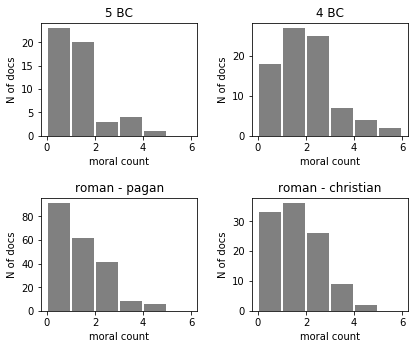

In [0]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(LG_data_results[LG_data_results["century"]==-4.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 0].set_title('5 BC')
axs[0, 1].hist(LG_data_results[LG_data_results["century"]==-3.5]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[0, 1].set_title('4 BC')
axs[1, 0].hist(LG_data_results[(LG_data_results["provenience"]=="pagan") & (LG_data_results["period"]=="roman")]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 0].set_title('roman - pagan')
axs[1, 1].hist(LG_data_results[LG_data_results["provenience"]=="christian"]["moral_count"], bins=[0,1,2,3,4,5,6], rwidth=0.9, color="gray")
axs[1, 1].set_title('roman - christian')

for ax in axs.flat:
    ax.set(xlabel='moral count', ylabel='N of docs')

plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
fig.savefig(gdrive_root + "figures/hist_moral_counts.png", bbox_inches="tight")

In [0]:
fig.savefig(gdrive_root + "figures/hist_moral_counts.png")

In [0]:
ecdf(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"])[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       5, 6])

In [0]:
sns.scatterplot(x = ecdf(LG_data_results["period"]=="classical"]["moral_count"])[0], y= ecdf(LG_data_results["period"]=="classical"]["moral_count"])[1])

SyntaxError: ignored

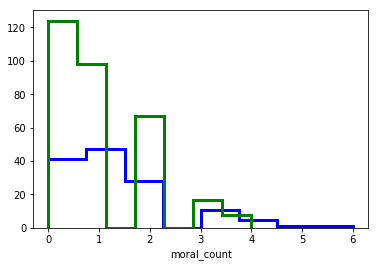

In [0]:
sns.distplot(LG_data_results[LG_data_results["period"]=="classical"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "b"})
sns.distplot(LG_data_results[LG_data_results["period"]=="roman"]["moral_count"], kde=False, hist_kws={"histtype": "step" , "linewidth": 3, "alpha": 1, "color": "g"})

In [0]:
 ax = sns.distplot(x, rug=True, rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, hist_kws={"histtype": "step", "linewidth": 3,    "alpha": 1, "color": "g"})

In [0]:
set_with_dataframe(sh.add_worksheet("results_by_centuries", cols=1, rows=1), LG_data_results.groupby("century")["moral_count"].describe().round(5))

In [0]:
LG_data_results[LG_data_results["provenience"]=="christian"].groupby("century")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
century,,,,,,,,
0.5,29.0,1.000000,0.707107,0.0,1.0,1.0,1.0,3.0
1.5,22.0,1.318182,0.994574,0.0,1.0,1.0,2.0,3.0
2.5,27.0,1.148148,1.321529,0.0,0.0,1.0,2.0,4.0
3.5,28.0,1.214286,1.031258,0.0,0.0,1.0,2.0,3.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,134.0,1.246269,1.197972,0.0,0.0,1.0,2.0,6.0
roman,314.0,1.003185,1.028347,0.0,0.0,1.0,2.0,4.0


In [0]:
import seaborn as sns


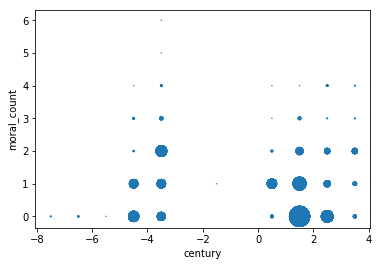

In [0]:
def like_me_here(row):
  like_me_here_count = len(LG_data_results[(LG_data_results["century"]== row["century"]) & (LG_data_results["moral_count"]== row["moral_count"])])
  return like_me_here_count
LG_data_results["like_me_here"] = LG_data_results.apply(lambda row: like_me_here(row), axis=1)

LG_data_results.plot.scatter(x="century", y="moral_count", s=(LG_data_results["like_me_here"]**2)/5)

In [46]:
proxies_df = sddk.read_file("https://sciencedata.dk/shared/2f7a60617c9171d2990a45902c6b1762?download", "df")
proxies_df

,century,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,-7.5,21250,87500,1.30,51.0,archaic,1.0,1.0,1.0
1,-6.5,21750,112500,2.50,49.0,archaic,1.0,1.0,1.0
2,-5.5,22500,137500,4.25,70.0,archaic,1.0,1.0,1.0
3,-4.5,23500,150000,6.35,149.0,classical,2.0,3.0,2.0
4,-3.5,25000,150000,8.25,230.0,classical,2.0,3.0,2.0
5,-2.5,26500,225000,7.95,NaN,None,NaN,NaN,NaN
6,-1.5,28000,350000,5.85,NaN,None,NaN,NaN,NaN
7,-0.5,30000,700000,4.70,NaN,None,NaN,NaN,NaN
8,0.5,31000,1000000,NaN,NaN,roman,3.0,2.0,2.0
9,1.5,30500,1000000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results = LG_data_results.merge(proxies_df, on="century")
LG_data_results.head(3)

,author,work,ids,length_orig,length_lemmata,provenience,century,notes,lemmata,nouns_and_adj,string,nouns_adj_length,theos_egonetwork,moral_terms,moral_count,kcal,settl,devindex,house,period,SocCx,AfflProg,AfflCons
0,Eutropius,Breviarium historiae romanae,stoa0121.stoa001.opp-grc1,26143,13086,pagan,3.5,None,"[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, γίγνομ...","[ῥωμαϊκός, βασίλεια, προοίμιον, οὐδείς, μεῖόν,...",Τῆς Ῥωμαϊκῆς βασιλείας ἐν προοιμίοις οὐδὲν ἐγέ...,8941,"[(προσηγορία, [an appellation, name], 0.25), (...",[],0,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
1,Hegemonius,Acta Archelai,stoa0146d.stoa001.opp-grc1,2725,1161,christian,3.5,None,"[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...","[μανιχαῖος, ἀπόστολος, ἰησοῦς, χριστός, πᾶς, ἅ...",Μανιχαῖος ἀπόστολος Ἰησοῦ Χριστοῦ καὶ οἱ σὺν ἐ...,727,"[(εἰρήνη, [peace, peace of mind], 1.0), (πατήρ...","[ἀγαθωσύνη, ἀγαθός, καλός]",3,28750,800000,NaN,NaN,roman,3.0,2.0,2.0
2,Ammonius Grammaticus,De adfinium vocabulorum differentia ΠΕΡΙ ΟΜΟΙΩ...,tlg0708.tlg001.1st1K-grc1,21952,8597,pagan,3.5,None,"[ἀβακιον, διαφέρω, ἄβαξ, πρᾶγμα, παρατίθημι, ἀ...","[ἀβακιον, ἄβαξ, πρᾶγμα, παρατίθημι, ἀβέβηλος, ...","A ἄβαξ καὶ ἀβακιον διαφέρει . ἄβαξ μὲν γάρ , ἐ...",5298,"[(μάχη, [strife, contention, quarrel], 0.5), (...",[ἄξιος],1,28750,800000,NaN,NaN,roman,3.0,2.0,2.0


In [0]:
LG_data_results.groupby("period")["moral_count"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
classical,124.0,1.258065,1.242021,0.0,0.0,1.0,2.0,6.0
roman,219.0,1.027397,1.057597,0.0,0.0,1.0,2.0,4.0


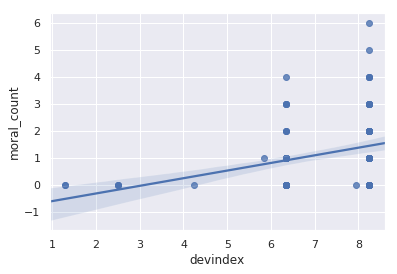

In [0]:
### see https://seaborn.pydata.org/tutorial/regression.html


sns.set(color_codes=True)
sns.regplot(x="devindex", y="moral_count", data=LG_data_results)

In [0]:
LG_data_results["author"] = LG_data_results.apply(lambda row: str(row["author"]), axis=1)

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [0]:
md = smf.mixedlm("moral_count ~ devindex", LG_data_results[LG_data_results["century"]<0], groups=LG_data_results[LG_data_results["century"]<0]["author"])
mdf = md.fit()
print(mdf.summary())


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: moral_count
No. Observations: 142     Method:             REML       
No. Groups:       27      Scale:              1.0455     
Min. group size:  1       Likelihood:         -214.4877  
Max. group size:  20      Converged:          Yes        
Mean group size:  5.3                                    
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept  -0.641     0.618  -1.037  0.300  -1.853   0.571
devindex    0.234     0.086   2.718  0.007   0.065   0.403
Group Var   0.213     0.111                               

